# Homework 3 - Places of the world

Travelling is a pleasant activity which has increased since the end of the COVID-19 pandemic. Nowadays, people look for places to visit which are attractive, affordable, with a rich history and which have recommended activities. Using user-generated content, Atlas Obscura, an American online magazine and travel firm, catalogues unusual and obscure tourist locations. The website's articles span many subjects, including history, science, cuisine, and unique places.

You and your team have been hired to provide your Data Science knowledge to create a search engine which will facilitate specific searches towards a topic related to the most popular places to visit. Important: All the functions must be implemented from scratch unless differently specified.

Then, let's get started!

## 1.1. Get the list of places

We start with the list of places to include in your corpus of documents. In particular, we focus on the Most popular places. Next, we want you to collect the URL associated with each site in the list from this list. The list is long and split into many pages. Therefore, we ask you to retrieve only the URLs of the places listed in the first 400 pages (each page has 18 places, so that you will end up with 7200 unique place URLs).

The output of this step is a .txt file whose single line corresponds to the place's URL.

To extract the URLs of the most popular places from the pages we can use a for loop iterating over the 400 pages scraping them using BeautifulSoup package: it will give us a BeautifulSoup object which represents the object as a nested data structure. Here we can find the URLs within a < a > tags which also has attribute class: content-card content-card-place. Then we can append every links that we found to a .txt file that we call 'links.txt'. All this work can be done defining a function that receives as input the number of the pages we want to analize and giving as output the .txt file. 

In [44]:
import requests

from bs4 import BeautifulSoup as bs

import numpy as np
import pandas as pd
import nltk.corpus
from nltk.corpus import stopwords
from cleantext import clean
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
import re
import math
from collections import Counter
import json
import warnings
warnings.filterwarnings("ignore")
import heapq

In [6]:
#we define a function which extract the links giving the number of the page
#that we want to analize and append them in a .txt file

def find_links(n):

  with open("/Users/giacomo/Desktop/ADM[HM3]/links.txt", "a") as file_object:

    for page in range(1, n+1):

      req = requests.get('https://www.atlasobscura.com/places?page=' + str(page) + '&sort=likes_count')

      soup = bs(req.text, 'html.parser')

      for link in soup.find_all('a', {'class': 'content-card content-card-place'}):

        file_object.write('https://www.atlasobscura.com' + str(link.get('href')) + '\n')

Now we can call the function to create a 'links.txt' file with all the URLs of the most popular places of the first 400 pages:

In [7]:
find_links(400)

## 1.2. Crawl places

Once you get all the URLs in the first 400 pages of the list, you:

Download the HTML corresponding to each of the collected URLs.
After you collect a single page, immediately save its HTML in a file. In this way, if your program stops for any reason, you will not lose the data collected up to the stopping point.
Organize the entire set of downloaded HTML pages into folders. Each folder will contain the HTML of the places on page 1, page 2, ... of the list of locations.

In [1]:
import os
import requests
import urllib
from random import randint
from time import sleep

Using .readlines() we collect the links of the document 'links.txt' (which contains the links of the previous point) in an array of links. Then we use 2 for cicle: 

- the first is used to create the main directories (e.g. page_1,page_2...). Each one will contain 18 .html files corresponding to the 18 places that every page have;

- The second is used to create the 18 .html file in the corresponding directory reading the url from the j-th element of the array of links ('lines'). At the end of every 'little cicle' we update the indexes of the start and the end to continue reading the links in block of 18 elements.

To avoid that our IP address get banned for the multiple requests in a very short amount of time we add pauses which help we us to be recognize as human that visited the website. Despite that, sometimes the execution stop. In these cases we updated the indexes of the 2 for cycle. 

In [3]:
file1 = open('/Users/giacomo/Desktop/ADM[HM3]/links.txt', 'r')

lines = file1.readlines()

parent_dir = "/Users/giacomo/Desktop/ADM[HM3]/files/"

start = 0

end = 18

for i in range(1, 401):
    
    directory = "page_" + str(i)
    
    path = os.path.join(parent_dir, directory)
    
    os.mkdir(path)
    
    for j in range(start, end):

        urllib.request.urlretrieve(lines[j], '/Users/giacomo/Desktop/ADM[HM3]/files' + '/' + directory + '/'+ str(j)+'.html')
        
    temp = end
        
    start = end
        
    end = temp +18
    
    sleep(randint(2,7))

## 1.3 Parse downloaded pages

At this point, you should have all the HTML documents about the places of interest, and you can start to extract the places' information. The list of the information we desire for each place and their format is as follows:

1. Place Name (to save as placeName): String.
2. Place Tags (to save as placeTags): List of Strings.
3. Number of people who have been there (to save as numPeopleVisited): Integer.
4. Number of people who want to visit the place(to save as numPeopleWant): Integer.
5. Description (to save as placeDesc): String. Everything from under the first image up to "know before you go" (orange frame on the example image).
6. Short Description (to save as placeShortDesc): String. Everything from the title and location up to the image (blue frame on the example image).
7. Nearby Places (to save as placeNearby): Extract the names of all nearby places, but only keep unique values: List of Strings.
8. Address of the place(to save as placeAddress): String.
9. Altitude and Longitude of the place's location(to save as placeAlt and placeLong): Integers
10. The username of the post editors (to save as placeEditors): List of Strings.
11. Post publishing date (to save as placePubDate): datetime.
12. The names of the lists that the place was included in (to save as placeRelatedLists): List of Strings.
13. The names of the related places (to save as placeRelatedPlaces): List of Strings.
14. The URL of the page of the place (to save as placeURL):String

For each place, you create a place_i.tsv file of this structure:

placeName \t placeTags \t  ... \t placeURL

If an information is missing, you just leave it as an empty string.

We decided to define a function to extract all the information we need taking as input the path of the file and giving as output the data. We used BeautifulSoup, in particular 'find_all' to explores the source code of the file searching for specifing tags to extract the data and 'select' that take as input a CSS selector. 

In [1]:
from bs4 import BeautifulSoup as bs
from datetime import datetime
import os
from tqdm import tqdm

In [2]:
file1 = open('/Users/giacomo/Desktop/ADM[HM3]/links.txt', 'r') #open the file with the URLs

lines = file1.readlines() #list of links

file1.close()

In [3]:
def find_info(path):
    
        f = open(path) #open .html
        
        soup = bs(f, 'html.parser') #convert the file in a beautifulsoup object
        #1 
        placeName = str(soup.find_all('h1', {'class': 'DDPage__header-title'})[0].contents[0])
        #2    
        placeTags = str(soup.find_all('div', {'class': 'DDPage__header-place-location'})[0].find_all(text = True))
        #3
        numPeopleVisited = int(soup.find_all('div', {'class': 'title-md item-action-count'})[0].contents[0])
        #4
        numPeopleWant = int(soup.find_all('div', {'class': 'title-md item-action-count'})[1].contents[0])
        #5
        placeDesc = ''.join(soup.find_all('div', {'id': 'place-body'})[0].find_all(text = True)).replace('\n', '')
        #6
        placeShortDesc = str(soup.find_all('h3', {'class': 'DDPage__header-dek'})[0].contents[0]).strip()
        #7
        placeNearby = [str(x.contents[0]) for x in soup.find_all('div', {'class': 'DDPageSiderailRecirc__item-title'})]
        #8
        placeAddress = (' '.join(soup.find_all('address', {'class': 'DDPageSiderail__address'})[0].find_all(text = True))).lstrip().rstrip()
        #9
        coordinates = ' '.join(soup.find_all('div', {'class': 'DDPageSiderail__coordinates js-copy-coordinates'})[0].find_all(text = True)).lstrip().rstrip().split(', ')
    
        placeAlt = float(coordinates[0])
    
        placeLong = float(coordinates[1])
    
        del coordinates
        #10
        placeEditors = []

        for i in soup.select('#ugc-module > div > div:nth-child(2) > div.DDPContributorsList > a'):
    
            if i.string != None: 
        
                placeEditors.append(str(i.string))
    
        for i in soup.select('li>a>span'): 
    
            if i.string != None: 
        
                placeEditors.append(str(i.string))
            
        #11
        
        placePubDate = ' '
        
        if len(soup.select('#ugc-module > div > div.DDPContributor__name')) != 0:
            
            if isinstance(soup.select('#ugc-module > div > div.DDPContributor__name')[0].text, str) == True:

                placePubDate = datetime.strptime(soup.select('#ugc-module > div > div.DDPContributor__name')[0].text.replace(',',''), '%B %d %Y').date()

            else: 

                placePubDate = soup.select('#ugc-module > div > div.DDPContributor__name')[0].text.strftime('%Y-%m-%d')
            
            
            
        
        #12 #13
    
        placeRelatedLists = []
    
        placeRelatedPlaces = []
        
        #find the part of the code which contain the part of our interest through parent and analyze them
    
        for x in soup.find_all('div', {'class': "CardRecircSection__title"}):
        
            if 'Appears' in x.get_text():
            
                for y in (x.parent.parent.parent).find_all('h3', {'class': "Card__heading --content-card-v2-title js-title-content"}): 
                
                    placeRelatedLists.append(y.get_text().strip())
                
            elif 'Related Places' in x.get_text(): 
            
                for y in (x.parent.parent.parent).find_all('h3', {'class': "Card__heading --content-card-v2-title js-title-content"}): 
                
                    placeRelatedPlaces.append(y.get_text().strip())
                    
        #14 
        
        #a) take the number of the file, aka the index in the file .txt from the path
        
        index = int((path.rsplit('/', 1)[-1]).replace('.html', ''))
            
        #b) extract the link from the .txt file of the 1.1 point of the homework
        
        placeURL = lines[index].strip()
         
        return([placeName, placeTags, numPeopleVisited, numPeopleWant, placeDesc, placeShortDesc, placeNearby, placeAddress, placeAlt, placeLong, placeEditors, placePubDate, placeRelatedLists, placeRelatedPlaces, placeURL])

An example on how it works: 

In [4]:
url = '/Users/giacomo/Desktop/ADM[HM3]/files/page_1/0.html'

print((find_info(url)[11]))

2010-05-08


Now we can explore all the .html file using 2 for cicle in a similar way of the previous point of the work. We extract the data using the function 'find_info' and we save them in a .tsv file with each value of attributes of each place separated by '\t' as indicated in the assignement: 

In [6]:
import pandas as pd
import csv

We decide to create a pandas dataframe. Then we add places info as rows and we save it in a .tsv file

In [7]:
df = pd.DataFrame(columns=['placeName', 'placeTags', 'numPeopleVisited', 'numPeopleWant', 'placeDesc', 'placeShortDesc', 'placeNearby', 'placeAddress', 'placeAlt', 'placeLong', 'placeEditors', 'placePubDate', 'placeRelatedLists', 'placeRelatedPlaces', 'placeURL'])


In [8]:
import warnings
warnings.filterwarnings('ignore')  #to remove the warning of the append method 

In [9]:
parent_dir = "/Users/giacomo/Desktop/ADM[HM3]/files/"

start = 0

end = 18

for i in tqdm(range(1, 401)):
    
    directory = "page_" + str(i)
    
    pat = os.path.join(parent_dir, directory)
    
    for j in range(start, end):
        
        data = find_info('/Users/giacomo/Desktop/ADM[HM3]/files' + '/' + directory + '/'+ str(j)+'.html')
        
        df = df.append({'placeName': data[0], 'placeTags': data[1], 'numPeopleVisited': data[2], 'numPeopleWant': data[3], 'placeDesc': data[4], 'placeShortDesc': data[5], 'placeNearby': data[6], 'placeAddress': data[7], 'placeAlt': data[8], 'placeLong': data[9], 'placeEditors': data[10], 'placePubDate': data[11], 'placeRelatedLists': data[12], 'placeRelatedPlaces': data[13], 'placeURL': data[14]}, ignore_index=True)
        
    temp = end
        
    start = end
        
    end = temp + 18

100%|█████████████████████████████████████████| 400/400 [37:42<00:00,  5.66s/it]


Then we export the data frame in a .tsv file: 

In [10]:
df.to_csv("/Users/giacomo/Desktop/ADM[HM3]/new_places2.tsv", sep="\t", index = False)


This is finally the complete dataset that we are searching for. 

In [11]:
places_df = pd.read_csv("/Users/giacomo/Desktop/ADM[HM3]/new_places2.tsv", sep='\t')


places_df.head(5)

,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAddress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedLists,placeRelatedPlaces,placeURL
0,City Hall Station,"['Manhattan, New York']",1828,8589,The first New York City subway was built and o...,A beautiful and abandoned New York subway stat...,"['African Burial Ground National Monument', 'T...","31 Centre St New York, New York, 10007 United ...",40.7134,-74.0046,"['Rebekah Otto', 'charding407', 'fosterc827', ...",2010-05-08,['30 Unexpected Places to Have a Joyful Advent...,"['Crystal Palace Subway', 'Moscow Metro Statio...",https://www.atlasobscura.com/places/city-hall-...
1,Highgate Cemetery,"['London, England']",2620,8192,"Opened in 1839, Highgate is one of London’s mo...",London's creepiest cemetery was once the site ...,"[""World's Largest Potted Plant"", 'Dick Whittin...","Swain's Lane, Highgate London, England, N6 Uni...",51.5675,-0.1483,"['TeaAndCoffeeLover', 'Collector of Experience...",2014-08-09,"[""The World's Top 100 Wonders in 2018"", ""Londo...","['Jewett City Vampires', 'Tomb of the Mather F...",https://www.atlasobscura.com/places/highgate-c...
2,Leadenhall Market,"['London, England']",3137,7575,The ornate 19th-century painted roof and cobbl...,This ornate Victorian marketplace was the sett...,"['The Cornhill Devils ', ""London's Original an...","London, England, EC3V United Kingdom",51.5126,-0.0834,"['Meg', 'Julius Spada', 'Katecrimson', 'thesec...",2016-08-01,"['The Ultimate Guide to Stunning, Surprising, ...","['Rivendell', 'Bagdad Cafe', 'Gare de la Ciota...",https://www.atlasobscura.com/places/leadenhall...
3,The Wave Organ,"['San Francisco, California']",2429,7415,"Located on a jetty in the San Francisco Bay, t...",A huge musical instrument played by the ocean.,"['Long Now Orrery', 'The Stern of the Briganti...","83 Marina Green Dr San Francisco, California, ...",37.8085,-122.4401,"['mbison', 'routt1111', 'wefiddleboy14', 'Saal...",2008-11-21,"[""Leonardo Nam's 16 Quirky Roadside Attraction...","['Sea Organ', 'Silent Green Kulturquartier', ""...",https://www.atlasobscura.com/places/wave-organ
4,Catacombes de Paris,"['Paris, France']",4449,7047,"In 2004, Parisian police were assigned to do a...","The vast, legendary catacombs hold secrets muc...","['Sculptures de Décure', 'Arago Medallions', ""...","1 Place Denfert-Rochereau Paris, 75014 France",48.8343,2.3322,"['CPilgrim', 'marypippen', 'ramonrodz2212', 'm...",2009-02-13,"['19 Catacombs Sure to Tingle Your Spine', ""Th...","['Ossario di San Martino', 'Leuk Charnel House...",https://www.atlasobscura.com/places/catacombes...


# 2. Search Engine

In [95]:
stop = stopwords.words('english') #stopwords in english 
ps = PorterStemmer() #takes the stem of words
def clean_text(text): 
    text.lower  #case normalization
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)  #removing unicode characters
    text = " ".join([word for word in text.split() if word not in stop and word.isalpha() == True]) #removing stopwords and 'numerical term
    token = word_tokenize(text) #tokenization
    text = [ps.stem(t) for t in token] #stemming and removing non english words
    return(" ".join(text))

## 2.1. Conjunctive query

### 2.1.1 Create your index!


In [96]:
df_for_last=pd.read_csv('places.tsv', sep='\t') # reading the places with pandas
df=df_for_last.copy()

for x,i in enumerate(df.loc[:,"placeDesc"]): #cleaning all text in  column
    df.loc[:,"placeDesc"][x]=clean_text(i)
    
word_list=[] 
string=""
for i in df.loc[:,"placeDesc"]: #string containing all words in the description descriptions to 
    string=string+i+" "
word_list.append(string) 
word_list=word_list[0].split()# getting wordlist out of the list and splitting all words and putting into a set to remove duplicates
word_list_set=set(word_list)

In [147]:
dictionary={i[1]:f"termId_{i[0]}" for i in enumerate(word_list_set)}#creates a dictionary from the set of words with term ids
dict(list(dictionary.items())[0:10])

{'pervers': 'termId_0',
 'productwith': 'termId_1',
 'halfsunk': 'termId_2',
 'sanctuaryd': 'termId_3',
 'langham': 'termId_4',
 'featuresto': 'termId_5',
 'barest': 'termId_6',
 'zelinski': 'termId_7',
 'ahaunt': 'termId_8',
 'plantat': 'termId_9'}

### Creating an inverted index

In [148]:
inverted_index={i:[] for i in dictionary.values()}
for x,y in enumerate(df.loc[:,"placeDesc"]):
    for i in y.split():
        if f"document_{x}" not in inverted_index[dictionary[i]]:
            inverted_index[dictionary[i]].append(f"document_{x}")
dict(list(inverted_index.items())[0:5])

{'termId_0': ['document_727',
  'document_1609',
  'document_3953',
  'document_4534',
  'document_5048'],
 'termId_1': ['document_6162'],
 'termId_2': ['document_2773'],
 'termId_3': ['document_235'],
 'termId_4': ['document_3603']}

#### Saving inverted index into a json file

In [126]:
with open("data.json", 'w') as fp: 
    json.dump(dictionary, fp)

Change and rerun this cell to **customize** the query and the k parameter.

In [127]:
query_input='City Hall Station'
k = 20

Documents which include all words in the query input

In [128]:
return_list=[]
for i in clean_text(query_input).split():
    term=dictionary[i]
    return_list.append(set(inverted_index[term]))
inter=[i for i in set.intersection(*return_list)]
inter[:10]

['document_2744',
 'document_5943',
 'document_4568',
 'document_3582',
 'document_4447',
 'document_0',
 'document_5981',
 'document_4963',
 'document_4444',
 'document_6263']

### Results of documents with query 

In [129]:
df_for_last.loc[[int(i.split("_")[1]) for i in inter],["placeName","placeDesc","placeURL"]]

,placeName,placeDesc,placeURL
2744,Catacombs of Old St. Patrick's Cathedral,The catacombs under the Old St. Patrick’s Cath...,https://www.atlasobscura.com/places/catacombs-...
5943,Site of the Beach Pneumatic Subway,Alfred Beach built this pneumatic tunnel to sh...,https://www.atlasobscura.com/places/beach-pneu...
4568,Moscow Metro Stations,"Subway stations are often sordid spots, the da...",https://www.atlasobscura.com/places/moscow-met...
3582,City Hall Urinal,There are plenty of public places to pee in Am...,https://www.atlasobscura.com/places/city-hall-...
4447,Mµseum - The Tiny Museum,The Mµseum (pronounced mew-zee-um) is too smal...,https://www.atlasobscura.com/places/museum-the...
0,City Hall Station,The first New York City subway was built and o...,https://www.atlasobscura.com/places/city-hall-...
5981,Kelly Butte Civil Defense Center,Kelly Butte is a long-extinct volcanic cinder ...,https://www.atlasobscura.com/places/kelly-butt...
4963,The Oldest Fence in New York,Most visitors to Bowling Green today come to s...,https://www.atlasobscura.com/places/the-oldest...
4444,Opa-Locka City Hall,In a city where the town hall is a sheik’s pal...,https://www.atlasobscura.com/places/opa-locka-...
6263,Toronto PATH,Not so hidden beneath the busy streets of Toro...,https://www.atlasobscura.com/places/toronto-path


## 2.2) Conjunctive query & Ranking score

## 2.2.1) Inverted index


In [130]:
word_list[:10]

['the',
 'first',
 'new',
 'york',
 'citi',
 'subway',
 'built',
 'oper',
 'interborough',
 'rapid']

#### TF's of documents

In [158]:
TFS=[]
N=len(df)
for i in df.loc[:,"placeDesc"]:
    tfs={}
    dene2=i.split()
    for x in dene2:
        tfs[x]=dene2.count(x)/len(dene2)
    TFS.append(tfs)
TFS
document_TFs=pd.DataFrame(TFS)
document_TFs = document_TFs.fillna(0)

document_TFs[:10]


,the,first,new,york,citi,subway,built,oper,interborough,rapid,...,literaturesh,scarlett,literatureamong,eroticaupd,hanyakbang,euljiro,establishmenthanyakbang,singleorigin,handdrip,cupit
0,0.010204,0.005102,0.015306,0.015306,0.030612,0.005102,0.005102,0.005102,0.005102,0.005102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.003390,0.003390,0.000000,0.000000,0.006780,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.017544,0.000000,0.000000,0.000000,0.005848,0.000000,0.011696,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.010526,0.002632,0.000000,0.000000,0.002632,0.000000,0.002632,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.011236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.000000,0.000000,0.000000,0.017751,0.005917,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.020833,0.000000,0.000000,0.000000,0.010417,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.016949,0.000000,0.033898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
new_inverted_index={i:[] for i in dictionary.values()}#empty inverted indexes
N = len(df)
for x,y in enumerate(df.loc[:,"placeDesc"]):
    splitted=y.split()
    splitted_tekrarlamaz=set(splitted)
    for i in splitted_tekrarlamaz:    
        key = dictionary[i]
        new_inverted_index[key].append([x,f"tfidf={document_TFs.loc[x][i]*math.log(N/len(inverted_index[dictionary[i]]))}"])
new_inverted_index
dict(list(new_inverted_index.items())[0:5])

{'termId_0': [[727, 'tfidf=0.054271629795298856'],
  [1609, 'tfidf=0.036001972240445775'],
  [3953, 'tfidf=0.009469268740325582'],
  [4534, 'tfidf=0.02703493826234218'],
  [5048, 'tfidf=0.030051233027148953']],
 'termId_1': [[6162, 'tfidf=0.048534624617508994']],
 'termId_2': [[2773, 'tfidf=0.05163858316862876']],
 'termId_3': [[235, 'tfidf=0.08001654328832564']],
 'termId_4': [[3603, 'tfidf=0.052246095911789095']]}

## 2.2.2) Execute the query

#### Creating relevant dataframe for calculating similarity of query to the document

In [161]:
# for every word in query its term_ID is learned from the dictionary and corresponding document numbers in inverted index are
#added to the "rdocs".These are the documents which has the query words in them.

query_input=clean_text(query_input)
return_list=[]
for i in query_input.split():
    term=dictionary[i]
    return_list.append(set(inverted_index[term]))
return_list=[i for i in set.intersection(*return_list)]

rdocs=return_list
rdocs_numbers=[int(i.split("_")[1]) for i in rdocs]


#### Number of documents that has the query words

In [162]:
dictionary_of_words_query={}
for word in query_input.split():
    count=0
    for document in df.loc[:,"placeDesc"]:
        if word in document.split():
            count+=1
    dictionary_of_words_query[word]=count
dictionary_of_words_query

{'citi': 1882, 'hall': 385, 'station': 383}

#### TF-IDF's of relevant words in documents

In [177]:
rTFIDFS={}
N = len(df)
for i in query_input.split():
    rTFIDFS[i]=[]
    tfidfs=[]
    dene2=i.split()
    for x in rdocs_numbers:
        rTFIDFS[i].append(df.loc[:,"placeDesc"][x].count(i)/len(df.loc[:,"placeDesc"][x].split())*(math.log(N/dictionary_of_words_query[i])))
document_TFIDFs=pd.DataFrame(rTFIDFS, index=rdocs_numbers)
document_TFIDFs


,citi,hall,station
2744,0.013154,0.028712,0.014381
5943,0.010649,0.023243,0.069852
4568,0.026569,0.028996,0.203333
3582,0.032994,0.048010,0.024048
4447,0.018810,0.013685,0.013709
0,0.041074,0.059767,0.179620
5981,0.045612,0.008296,0.008311
4963,0.019804,0.010807,0.010826
4444,0.043282,0.056682,0.018928
6263,0.029489,0.016091,0.048359


In [164]:
#new dataframe for documents including query

relevant_df=document_TFIDFs.loc[rdocs_numbers][query_input.split()]


In [178]:
relevant_df

,citi,hall,station
2744,0.013154,0.028712,0.014381
5943,0.010649,0.023243,0.069852
4568,0.026569,0.028996,0.203333
3582,0.032994,0.048010,0.024048
4447,0.018810,0.013685,0.013709
0,0.041074,0.059767,0.179620
5981,0.045612,0.008296,0.008311
4963,0.019804,0.010807,0.010826
4444,0.043282,0.056682,0.018928
6263,0.029489,0.016091,0.048359


#### Calculating the similarity between query and documents

In [165]:
dictionary_of_words_query={}
for word in relevant_df:
    count=0
    for document in df.loc[:,"placeDesc"]:
        if word in document.split():
            count+=1
    dictionary_of_words_query[word]=count
dictionary_of_words_query    

{'citi': 1882, 'hall': 385, 'station': 383}

In [174]:
#TFIDF of query
query_tfIDFs=[]
for x in query_input.split():
    query_tfIDFs.append(query_input.split().count(x)/len(query_input.split())*  (math.log(N/dictionary_of_words_query[x])))
query_tfIDFs

[0.44724866161960725, 0.9761976569054541, 0.9779337719411668]

In [222]:
#||Query||
add=0
for i in query_tfIDFs:
    add+=i*i    
Query_L=math.sqrt(add)   

#Similarities of all documents
similarity_list=[]
for i in relevant_df.index:
    add1=0
    for x in relevant_df.loc[i]:
        add1+=x*x    
    Document_L=math.sqrt(add1) 
    score = np.dot(query_tfIDFs,relevant_df.loc[i])/(Query_L*Document_L)
    if(len(similarity_list) <k):
        heapq.heappush(similarity_list,(score, i))
    else:
        new = np.dot(query_tfIDFs,relevant_df.loc[i])/(Query_L*Document_L)
        old = heapq.heappop(similarity_list)
        if(old[0]<score):
            heapq.heappush(similarity_list,(score, i))
        else:
            heapq.heappush(similarity_list, old)

#### Results

In [223]:
k_docs = [heapq.heappop(similarity_list) for i in range(0,len(similarity_list))]
k_docs_number = [x[1] for x in reversed(k_docs)]
k_docs_score = [x[0] for x in reversed(k_docs)]

sonuc_new=df_for_last.loc[k_docs_number,["placeName","placeDesc","placeURL"]]
sonuc_new.insert(3,"similarity",k_docs_score)

#add similarity list at the end of the dataframe

In [224]:
sonuc_new

,placeName,placeDesc,placeURL,similarity
3465,The Forgotten Entrance to Clinton Hall,This blocked up doorway on a subway station ho...,https://www.atlasobscura.com/places/the-forgot...,0.990361
1004,Short Story Vending Machine,Staring blankly into space while riding on a t...,https://www.atlasobscura.com/places/short-stor...,0.966009
2744,Catacombs of Old St. Patrick's Cathedral,The catacombs under the Old St. Patrick’s Cath...,https://www.atlasobscura.com/places/catacombs-...,0.951903
3582,City Hall Urinal,There are plenty of public places to pee in Am...,https://www.atlasobscura.com/places/city-hall-...,0.930180
4447,Mµseum - The Tiny Museum,The Mµseum (pronounced mew-zee-um) is too smal...,https://www.atlasobscura.com/places/museum-the...,0.897086
0,City Hall Station,The first New York City subway was built and o...,https://www.atlasobscura.com/places/city-hall-...,0.897056
6263,Toronto PATH,Not so hidden beneath the busy streets of Toro...,https://www.atlasobscura.com/places/toronto-path,0.890909
5943,Site of the Beach Pneumatic Subway,Alfred Beach built this pneumatic tunnel to sh...,https://www.atlasobscura.com/places/beach-pneu...,0.886431
4444,Opa-Locka City Hall,In a city where the town hall is a sheik’s pal...,https://www.atlasobscura.com/places/opa-locka-...,0.869698
1090,Euston's Lost Tunnels,A portal into the London Underground’s past hi...,https://www.atlasobscura.com/places/eustons-lo...,0.845030


# 3. Define a new score!

In [229]:
query_input = 'Catacombs of Old St. Patrick Cathedral'

In [225]:
df=pd.read_csv('places.tsv', sep='\t') # reading the places with pandas
df_copy = df.copy() ## Store a copy with original not cleaned test

#Since I'm gonna exploit more columns and not just placeDesc, I'm gonna create a list of the column I intend to use.
columnNames = ["placeName","placeShortDesc","placeDesc", "placeTags",	"placeAddress"]

for columnName in columnNames:
  for x,i in enumerate(df.loc[:,columnName]): #cleaning all text in  column
      df.loc[:,columnName][x]=clean_text(i)
    
word_list=[] 
string=""
for columnName in columnNames:
  for i in df.loc[:,columnName]: #string containing all words in the column
      string=string+i+" "

word_cnt = string.split() # getting wordlist out of the list, splitting all words and putting into a counter 
word_cnt = Counter(word_cnt) # now I have, for each word, how many times it occours in all the documents. 
#Plus, if I need to iterate on a set of these words (meaning if I want to iterate on the words without duplicates)
#all I need to do is iterate on the counter keys


In [226]:
#creates a dictionary from the counter of words, the result is a dicionary in the form {'word':word_id} where word_id is a string 'term_ id_number'
dictionary={i[1]:f"term_id_{i[0]}" for i in enumerate(word_cnt)}

In [231]:
#Builds a dictionary of inverted index from the previous dictionary, 
#where every element has as key the term_id and as value the articles ids in which this word appears
inverted_index={i:[] for i in dictionary.values()}

In [232]:
#Here we iterate the articles in the dataframe and, for each column and foreach word in that column,
# we register (if not present) the fact that that word is present in that document.

#After this, inverted_index is something like this {'term_id': [list of document in which this word appears]}
for columName in columnNames:
  for x,text in enumerate(df.loc[:,columName]):
    for word in text.split():
      if f"document_{x}" not in inverted_index[dictionary[word]]:
        inverted_index[dictionary[word]].append(f"document_{x}")

In [235]:
from numpy.linalg import norm
from math import isnan

#We execute the query: 
#  first, we clean the query so that the words have the same look of the ones in the dictionary
#  then, we store in a list the documents that have one of the word 
#  we then use intersection to keep only the document that have all the words in our query
#we return the list of those documents
def execute_query(query):
  'Input: query given in input'
  'Output: documents id in which the word appears'
  query = clean_text(query)
  return_list = []
  for i in query.split():
    try:
      term=dictionary[i]
    except KeyError as e:
      continue
    return_list.append(set(inverted_index[term]))
  if (len(return_list)==0):
    return []  
  inter = [i for i in set.intersection(*return_list)]
  return inter

def cos_sim(A, B):
   ##cosine similarity = dot product of the vectors divided by the product of their norms
    dotProd = (np.dot(A,B))
    norms = norm(A)*norm(B)
    return 0 if norms == 0 else dotProd/norms

## Return docum number from id (document id is like 'document_NumberOfDocument')
def getDocNumberFromId(documId):
  start = documId.find('_')+1
  return int(documId[start:len(documId)])


In [238]:
query_result = execute_query(query_input)
query_result

['document_2744',
 'document_5943',
 'document_4568',
 'document_3582',
 'document_4447',
 'document_0',
 'document_5981',
 'document_4963',
 'document_4444',
 'document_6263',
 'document_1090',
 'document_3465',
 'document_1004',
 'document_2867']

The inverse document frequency (idf) is a measure of how much information the word provides. In other words, it tells you if the word is common across all documents. <br>
It is the logarithm of the total number of documents divided by the number of documents containing the term. The more it's high, more the word is rare. 

In [239]:
def getIdf(word, N):
  'Input:'
  ' word: word for which we want to compute idf'
  ' N: number of document present in the dataset'
  'Output: the idf of the word'
  i = len(inverted_index[dictionary[word]]) ## number of documents in which the word appears
  if i == 0: 
    return 0
  return np.log(N/i)

idf = {}
N = len(df_copy)
## Compute the idf for each word present in the select columns of the dataset
for word in word_cnt:
  idf[word] = getIdf(word,N)

The term frequency (tf) is the relative frequency of a word in a document. <br> It's obtained by dividing the number of times a word appears in a document by the total number of words in a document.

In [245]:
# In this list, the columns are ordered by importance to my score:
## Every time we compute tf for a specific column, that will be divided by how important that column is.
## In my opinion, the most important column is placeName, because the title is the most relevant summary of the
## document's content, so if a word is contained in the title, its frequency will be doubled.
## In the same way, placeShortDesc is pretty important so no division will be involved,
## while the rest are less important so a small division will occur.
columnNames = ["placeName","placeShortDesc","placeDesc", "placeTags",	"placeAddress"]
def getWordFrequency(word, documentNumber):
  score = 0.0
  frequency_in_doc = 0.0
  frequency_all = 0.0
  tmp = 0.0
  for i in range(0,len(columnNames)):
    div = i
    if(i==0):
      div=0.5
    div = 1/div
    frequency_in_doc=df.loc[documentNumber,columnNames[i]].count(word)*div
    frequency_all=len(df.loc[documentNumber,columnNames[i]].split())
    if(frequency_all >0):
      tmp += frequency_in_doc/frequency_all
  score = tmp
  return score

In [246]:
##The score for each word of the query will be its tf-idf
def getQueryScore(qInputList):
  tf = []
  query_cnt = Counter(qInputList)
  len_query = len(qInputList)
  for word in query_cnt:
    tf.append((query_cnt[word]/len_query)*np.log(idf[word]))
  return tf

In [249]:
#Here we build an heap in which we put, for every document, its score. 
#Since we use the build-in tool heapq, we multiply this score for -1, so that the elements are sorted in descending order.

resultHeap = []
queryInputList = clean_text(query_input).split()
queryTf = getQueryScore(queryInputList)
for docId in query_result:
  tf_idf = []
  documentNumber = getDocNumberFromId(docId)
  for word in queryInputList:
    tf_idf.append(getWordFrequency(word, documentNumber)*idf[word])
  score = cos_sim(np.array(getQueryScore(queryInputList)),np.array(tf_idf))
  element = (score, docId)
  if(len(resultHeap)==k):
    old_min_score = heapq.heapop(resultHeap)
    if(score<=old_min_score[0]):
      element = old_min_score
  heapq.heappush(resultHeap, element)

In [250]:
#We take the first k document (or less if the resultHeap is smaller)
if (len(resultHeap) < k):
  max = len(resultHeap)

docsInfo = [heapq.heappop(resultHeap) for i in range(0,max)]

#So that the element with bigger score will be on top
docsInfo.reverse()

In [251]:
top_k = df_copy.loc[[getDocNumberFromId(i[1]) for i in docsInfo]]
top_k_score = [i[0] for i in docsInfo]
top_k['score'] = top_k_score
top_k[['placeName','placeDesc','placeURL','score']]

,placeName,placeDesc,placeURL,score
0,City Hall Station,The first New York City subway was built and o...,https://www.atlasobscura.com/places/city-hall-...,0.989693
1004,Short Story Vending Machine,Staring blankly into space while riding on a t...,https://www.atlasobscura.com/places/short-stor...,0.922755
5943,Site of the Beach Pneumatic Subway,Alfred Beach built this pneumatic tunnel to sh...,https://www.atlasobscura.com/places/beach-pneu...,0.896542
2867,Rungis International Market,"Five miles south of Paris, in a suburb called ...",https://www.atlasobscura.com/places/rungis-int...,0.858587
3465,The Forgotten Entrance to Clinton Hall,This blocked up doorway on a subway station ho...,https://www.atlasobscura.com/places/the-forgot...,0.850422
6263,Toronto PATH,Not so hidden beneath the busy streets of Toro...,https://www.atlasobscura.com/places/toronto-path,0.849627
4447,Mµseum - The Tiny Museum,The Mµseum (pronounced mew-zee-um) is too smal...,https://www.atlasobscura.com/places/museum-the...,0.830781
4568,Moscow Metro Stations,"Subway stations are often sordid spots, the da...",https://www.atlasobscura.com/places/moscow-met...,0.787208
4963,The Oldest Fence in New York,Most visitors to Bowling Green today come to s...,https://www.atlasobscura.com/places/the-oldest...,0.743059
1090,Euston's Lost Tunnels,A portal into the London Underground’s past hi...,https://www.atlasobscura.com/places/eustons-lo...,0.718009


### Report

The new query is pretty different from the previous one since it explore more than one cell. This is done in order to show to the user as many results as possible, since the goal is to keep the user on the search engine for as much time as possible. Exploring more cells is expecially important for queries that have only a few matches (es. try executing the query *'software engineer'*), because it allows to give more feedbacks to the user.<br> Setting the query aside, let's talk about the score. I think the new score is more efficient than the old one: let's take, for example, the query *'City Hall Station'*, in the new score, the article with the title 'City Hall Station' is in first position and that's correct since it's the one with most correlation. But with the old score, this article is only sixth. That's because most of the times considering the description as the only and most important source of information can lead to erroneous conclusion.

# 4. Visualizing the most relevant places


In [294]:
import plotly.express as px

fig = px.scatter_mapbox(top_k, lat= 'placeAlt', lon = 'placeLong', hover_name = 'placeName', hover_data=["numPeopleVisited", "placeAddress"], color_discrete_sequence=["red"], zoom=2,  height = 600, size="score",
                        labels={"placeAlt":"Lat.", "placeLong": "Long.", "numPeopleVisited": "Visitors", "placeAddress":"Address"})
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0, "t":0, "l":0, "b":0})
fig.show()

# 5. BONUS: More complex search engine

IMPORTANT: This is a bonus step, so it's not mandatory. You can get the maximum score also without doing this. We will take this into account, only if the rest of the homework has been completed.

For the Bonus part, we want to ask you more sophisticated search engine. Here we want to let users issue more complex queries. The options of this new search engine are:

1. Give the possibility to specify queries for the following features (the user should have the option to issue none or all of them):

    -placeName
    
    -placeDesc
    
    -placeAddress
    

2. Specify a list of usernames to only retrieve the posts that all of these users contributed to.
3. Specify a list of tags which the search engine should only return the places that are tagged with all of those tags.
4. Filter based on the number of people who have already been there. The user should be able to adjust the upperbound, lowerbound or only one of the two.
5. Specify a list of the list names that the engine should only filter the documents that have been included in all of the given list names.

Note 1: You should be aware that you should give the user the possibility to select any of the abovementioned options. How should the user use the options? We will accept any manual that you provide to the user.

Note 2: As you may have realized from 1st option, you need to build inverted indexes for those values and return all of the documents that have the similarity more than 0 concerning the given queries. Choose a logical way to aggregate the similarity coming from each of them and explain your idea in detail.

Note 3: The options other than 1st one can be considered as filtering criteria so the retrieved documents must respect all of those filters.

The output must contain the following information about the places: 

    -placeName
    -placeURL
 

    

## Readme
This bonus point is divided into two parts: in the first part we show in details the construction of the components of the search engine (made by the user interface to insert the query, the calculus of the similarity' and the filters; in the second part ($\textbf{Final result}$)  all this component are merged togheter. 

So if you wanna check only the final result and use the search engine please run all and go ahead to the last point.

# 5.1 Collect the information needed to define the query

In this step we decide to create a sort of 'interactive' interface that collect the information to build your query. The code is a little bit heavy but it is so simple: it's all built with if-else trees and print sentences every step to give you the manual on how to insert your query. The only thing that the user have to do is to execute this cell and follow the instruction. The final result will be a collection of variable that will be used to build the query in the following cell. 


This code allow to the users to decide which info he wanna insert and which not. After all the questions made by the 'system' the user will also be able to see the information that he insert and also start again the research if he do something wrong. The result will be the creation of the variable that will composed the query:

Name: 'string'

Description: 'string'

Address: 'string

List of Username: 'list'

PlaceTags: 'list' 

Upperbound: 'int'

Lowerbound: 'int'

Related list: 'list'

The users doesn't have to know everything, just run the cell and follow the instructions. 

In [259]:
def user_interface():
    print("Hi, i'm your search engine. Let's start collecting info about your interest. Say 'continue' everytime you wanna do a new research :)")
    
    
    global name, desc, address, list_of_users, placeTag, up, low, related_list
    
    res = input().lower()

    while res == 'continue':

        #1

        print("First of all we wanna collect the information that you need to search...")

        print("How many features do you wanna insert between 'placeName', 'placeDesc' and 'placeAddress'. Digit a number between 0 and 3.")

        n_1 = input()

        if n_1 == str(3):

            print("Please digit the placeName")

            name = input()

            print("Please digit the placeDesc")

            desc = input()

            print("Please digit the placeAddress")

            address = input()

        elif n_1 == str(2): 

            print("Which one do you wanna insert ('placeName', 'placeDesc' or 'placeAddress')? Please digit the two features separated by enter command")

            l = [input().lower(), input().lower()]

            if "placename" in l and "placedesc" in l: 

                print("Please insert the placeName")

                name = input()

                print("Please insert the placeDesc")

                desc = input()

                address = 'None'

            elif "placename" in l and 'placeaddress' in l:

                print("Please insert the placeName")

                name = input()

                print("Please insert the placeAddress")

                address = input()

                desc = 'None'

            elif "placedesc" in l and 'placeaddress' in l: 

                print("Please insert the placeDesc")

                desc = input()

                print("Please insert the placeAddress")

                address = input()

                name = 'None'

            else: 

                print("You have probably written something wrong, please restart the search engine :(")

        elif n_1 == str(1):

            print("Which one do you wanna insert ('placeName', 'placeDesc' or 'placeAddress')?")

            if input().lower() == 'placename':

                print("insert the placeName")

                name = input()

                desc = 'None'

                address = 'None'

            elif input().lower() == 'placedesc':

                print("insert the placeDesc")

                desc = input()

                name = 'None'

                address = 'None'

            elif input().lower() == 'placeaddress': 

                print("insert the placeAddress")

                address = input()

                name = 'None'

                address = 'None'

            else: 

                print("You have probably written something wrong, please restart the search engine :(")

        elif n_1 ==str(0): 

            print("You haven't choose none of them. Let's continue :) ")

            name = 'None'

            address = 'None'

            desc = 'None'

        #2

        print("Do you wanna filter your research based on username? \n I'll check if one of the users that you digit worked on the article. \n Answer 'yes' or 'no'. ")

        n_2 = input().lower()

        list_of_users = []

        if n_2 == 'no': 

            print("So let's continue with the next question :) ")

        elif n_2 == 'yes': 

            print("How many users do you wanna insert? Please insert a number.")

            n_us = int(input())

            print("Insert the users pressing enter after each insertion: ")

            for i in range(n_us): 

                list_of_users.append(input())

            print("Are you happy with your choice? Press 'yes' or 'no'. You can read your insertion below: ")

            for i in range(len(list_of_users)): 

                print(list_of_users[i])

            answer = input().lower()

            if answer == 'yes': 

                print("So let's continue with the next question :) ")

            elif answer == 'no':

                print("Insert the users pressing enter after each insertion. You have only one more chance.")

                list_of_users = []

                for i in range(n_us): 

                    list_of_users.append(input())

                print("You can read your insertion below: ")

                for i in range(len(list_of_users)): 

                    print(list_of_users[i])

                print("So let's continue with the next question :) ")


        #3        

        print("Do you wanna insert any placeTags? Digit 'yes' or 'no'")

        n_3 = input().lower()

        if n_3 == 'no':
            
            placeTag = 'None'

            print("So let's continue with the next question :) ")

        elif n_3 == 'yes': 

            print("Insert the placeTags space separated: ")

            placeTag = input()

            print("You have inserted the following placetags, are you happy with that? Say 'yes' or 'no'")
            
            ##
            print(placeTag)
            
            answer_2 = input()

            if answer_2 == 'yes':

                print("So let's continue with the next question :) ")

            elif answer_2 == 'no': 

                print ("Insert the placeTag space separated. You have only one more chance.")

                placeTag = input()
                

                print("So let's continue with the next question :) ")

        #4

        print("Do you wanna filter by number of people who have already been there? Digit 'yes' or 'no'")

        answer_3 = input().lower()

        if answer_3 == 'no':

            print("So let's continue with the next question :) ")

            up = 0

            low = 0

        elif answer_3 =='yes': 

            print("Insert a lowerbound. Press '0' if you don't wanna specify that")

            low = int(input())

            if low == 0:

                print("So let's continue with the next question :) ")

            if low != 0:

                print("You have inserted " + str(low) + " as lowerbound")

            print("Insert a upperbound. Press '0' if you don't wanna specify that")

            up = int(input())

            if up == 0:

                print("So let's continue with the next question :) ")

            if up != 0:

                print("You have inserted " + str(up) + " as upperbound")


        #5

        print("Do you wanna filter by list in which the places are include? Please say 'yes' or 'no'")

        answer_5 = input()
        

        if answer_5 == 'no':
            
            related_list = 'None'

            print("Ok. The following lines are the info that we collected for your query: ")
            print("Name: " + name + "\n" + "Description: " + desc + '\n' + "Address: " + address)
            print("List of Username: ")
            print(list_of_users)
            print("PlaceTags: ")
            print(placeTag)
            print("Upperbound: " + str(up))
            print("Lowerbound: " + str(low))
            print("Related list: ")
            print(related_list)
            
            

        elif answer_5 == 'yes':

            print("Insert the keywords for the list that u are searching for space separated :)")
            
            related_list = input()

            print("Are you happy with your choice? Say 'yes' or 'no'. You can see below your insertion: ")

            print(related_list)
            
            answer_7 = input()

            if answer_7 =='yes':

                print("Ok. The following lines are the info that we collected for your query: ")
                print("Name: " + name + "\n" + "Description: " + desc + '\n' + "Address: " + address)
                print("List of Username: ")
                print(list_of_users)
                print("PlaceTags: ")
                print(placeTag)
                print("Upperbound: " + str(up))
                print("Lowerbound: " + str(low))
                print("Related list: ")
                print(related_list)


            if answer_7 == 'no': 

                related_list = []

                print("Insert the keywords for the list that u are searching for space separated :). It's your last try :(")

                related_list = input()

                print("Ok. The following lines are the info that we collected for your query: ")
                print("Name: " + name + "\n" + "Description: " + desc + '\n' + "Address: " + address)
                print("List of Username: ")
                print(list_of_users)
                print("PlaceTags: ")
                print(placeTag)
                print("Upperbound: " + str(up))
                print("Lowerbound: " + str(low))
                print("Related list: ")
                print(related_list)

        print("Do you wanna stop here? Say 'yes' or 'no'. If no the research will restart.")

        final = input().lower()

        if final == 'yes':

            break

        if final =='no':

            print("Let's digit 'continue' in the next box to restart the research. Digit anything else if you wanna stop.")


In [260]:
user_interface()

Hi, i'm your search engine. Let's start collecting info about your interest. Say 'continue' everytime you wanna do a new research :)


 continue


First of all we wanna collect the information that you need to search...
How many features do you wanna insert between 'placeName', 'placeDesc' and 'placeAddress'. Digit a number between 0 and 3.


 3


Please digit the placeName


 citi


Please digit the placeDesc


 new york


Please digit the placeAddress


 new york


Do you wanna filter your research based on username? 
 I'll check if one of the users that you digit worked on the article. 
 Answer 'yes' or 'no'. 


 yes


How many users do you wanna insert? Please insert a number.


 0


Insert the users pressing enter after each insertion: 
Are you happy with your choice? Press 'yes' or 'no'. You can read your insertion below: 


 yes


So let's continue with the next question :) 
Do you wanna insert any placeTags? Digit 'yes' or 'no'


 no


So let's continue with the next question :) 
Do you wanna filter by number of people who have already been there? Digit 'yes' or 'no'


 no


So let's continue with the next question :) 
Do you wanna filter by list in which the places are include? Please say 'yes' or 'no'


 no


Ok. The following lines are the info that we collected for your query: 
Name: citi
Description: new york
Address: new york
List of Username: 
[]
PlaceTags: 
None
Upperbound: 0
Lowerbound: 0
Related list: 
None
Do you wanna stop here? Say 'yes' or 'no'. If no the research will restart.


 yes


## 5.2 Search Engine

### 5.2.1 Define the 'cleaning function':


In [262]:
stop = stopwords.words('english')

ps = PorterStemmer()

We define a function that do the text cleaning in 4 steps:

    -Case normalization
    -Remove Unicode Character
    -Remove stopwords and 'numerical terms'
    -Stemming

In [267]:
def clean_text(text): 
    
    text.lower()  #case normalization
    
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)  #removing unicode charachters

    text = " ".join([word for word in text.split() if word not in stop and word.isalpha() == True]) #removing stopwords and 'numerical term
    
    token = word_tokenize(text) #tokenization
    
    text = [ps.stem(t) for t in token] #stemming
    
    return(str(" ".join(text)))

Below we have an example on how it work: 

In [266]:
txt = 'hi, Looking) wife beautiful addre44. the house. patch house winchester santamaria'

print(clean_text(txt))

hi look wife beauti hous patch hous winchest santamaria


### 5.2.2 Create the dataframe where the query is executed:

We decided to create a dataframe with the columns 'placeName' (filtered), 'placeTags' (filtered), 'numPeopleVisited', 'placeDesc' (filtered), 'placeAddress' (filtered), 'placeEditors', 'placeRelatedLists' (filtered) where filtered mean normalized, with no punctuation and stopword and stemmed. 

In [273]:
import csv
from tqdm import tqdm 

In [281]:
df = pd.DataFrame(columns=['placeName', 'placeTags', 'numPeopleVisited', 'placeDesc', 'placeAddress', 'placeEditors', 'placeRelatedLists', 'placeURL'])

with open('places.tsv', encoding='utf-8') as f:
    
    rows = csv.DictReader(f, delimiter = '\t')
    
    for r in tqdm(rows):
        df = df.append({'placeName': clean_text(r['placeName']), 'placeTags': clean_text(r['placeTags']), 'numPeopleVisited': r['numPeopleVisited'], 'placeDesc': clean_text(r['placeDesc']), 'placeAddress': clean_text(r['placeAddress']), 'placeEditors': r['placeEditors'], 'placeRelatedLists': clean_text(r['placeRelatedLists']), 'placeURL': r['placeURL']}, ignore_index=True)
        


7200it [01:40, 71.96it/s] 


In [282]:
df.head()

,placeName,placeTags,numPeopleVisited,placeDesc,placeAddress,placeEditors,placeRelatedLists,placeURL
0,citi hall station,manhattan new york,1828,the first new york citi subway built oper inte...,centr st new york new york unit state,"['Rebekah Otto', 'charding407', 'fosterc827', ...",unexpect place have joy adventur new york citi...,https://www.atlasobscura.com/places/city-hall-...
1,highgat cemeteri,london england,2620,open highgat one london infam cemeteri origin ...,swain lane highgat london england unit kingdom,"['TeaAndCoffeeLover', 'Collector of Experience...",the world top wonder london top wonder favorit...,https://www.atlasobscura.com/places/highgate-c...
2,leadenhal market,london england,3137,the ornat paint roof cobbl floor leadenhal mar...,london england unit kingdom,"['Meg', 'Julius Spada', 'Katecrimson', 'thesec...",the ultim guid stun surpris hidden film locat ...,https://www.atlasobscura.com/places/leadenhall...
3,the wave organ,san francisco california,2429,locat jetti san francisco bay wave organ built...,marina green dr san francisco california unit ...,"['mbison', 'routt1111', 'wefiddleboy14', 'Saal...",leonardo nam quirki roadsid attract the world ...,https://www.atlasobscura.com/places/wave-organ
4,catacomb de pari,pari franc,4449,in parisian polic assign train exercis previou...,place denfertrochereau pari franc,"['CPilgrim', 'marypippen', 'ramonrodz2212', 'm...",catacomb sure tingl your spine the world top w...,https://www.atlasobscura.com/places/catacombes...


### 5.2.3 Create TFIDF 

The TF is a measure of the frequency of a word in the documents and can be calculated as: 


$TF(word, document)=\frac{occurrence of the word in the document}{total number of words}$


The IDF is a measure of the importance of a word calculated as: 


$IDF(w, corpus) = ln (\frac{num ofdocuments}{num ofdocs with word})$

The TFIDF is the product of TF and IDF that: 

 - gives more weight that rarely appears in documents
 - gives more importance to the words that are more frequent in a document
 
In this way the represent the text in the documents as vector of the same dimension of the vocabulary, with the values that correspond to the importance of the word in a document.

To calculate we used the sklearn package where we can find the functions to vectorize the documents and the query, calculate the TFIDF matrix and calculate the cosine similarity.


In [274]:
from sklearn.feature_extraction.text import TfidfVectorizer  #for the vectorization  
from sklearn.metrics.pairwise import cosine_similarity #for the cosine similarity

vectorizer = TfidfVectorizer()  #to get the tfidf matrix

### 5.2.4 How to calculate the similarity between query and documents: 

We have a query which contains:

    -placeName
    -placeDesc
    -placeAddress
    -placeEditors 
    -placeTags
    -Upperbound and lowerbound to numPeopleVisited
    -placeRelatedLists
    
 
    
So the $\textbf{idea}$ is made up 5 step:  

    1) Calculate the cosine similarity between docs and query separately for placeName, placeDesc, placeAddress, placeTags and  placeRealatedLists. 
 
    2) Merge them in a 'total similarity' measure by multiply their cosine similarity: the result will be a number between 0 and 1 (the higher, the similar to the query).
    
    (NB: This two points will be implemented in add_sim() function)
    
    3) Find the top k documents sorting by similarity
    
    4) Filter by the username of the editor and the upper/lowerbound
    
    5) Print the result of the research
    
Naturally if some part of the query are not present the code will follow a different way skipping the steps that are not requested.

Maybe a future improvement for that could be give different weights to the part of the query as grade of importance. In this way for example placeName will be more significant and the other will have the same weight. For example we could choose something like: 
    
    - $weight_{name}= 0.6$
    - $weight_{address}= 0.1$
    - $weight_{desc}= 0.1$
    - $weight_{tag}= 0.1$
    - $weight_{list}= 0.1$


In [275]:
#define function that take as input the dataframe and the query
#return a dataframe with a column called 'total similarity'. 


def add_sim(data, query):
    
    #Calculate the cosine similarity separately:
    
    #1 name
    
    if query[0] != 'None':                                                          

        tfidf_1 = vectorizer.fit_transform(data['placeName'])        #store the tfidf of the documents
                                                            #tfidf represent the vector created with the description 
                                                            #using TFIDF vectorization
            
        
        vector_name = vectorizer.transform([clean_text(query[0])])          #'clean' and vectorize the query

        cos_name = cosine_similarity(tfidf_1,vector_name) 
        
        #calculate cosine similarity betweeen query and documents
        
    else:
          
        cos_name = np.expand_dims(np.ones(7200), axis = 1)    #if the user don't wanna search by a features
                                                              #the similarity will be one 
                                                              #such that the moltiplication doesn't affect the result 
    #2 description
    if query[1] != 'None':
        
        tfidf_2 = vectorizer.fit_transform(data['placeDesc'])
        
        vector_desc = vectorizer.transform([clean_text(query[1])])
        
        cos_desc = cosine_similarity(tfidf_2,vector_desc)
        
    else: 
        
        cos_desc = np.expand_dims(np.ones(7200), axis = 1)    #to multiply without affect the result
    
    #3 address
    
    if query[2] != 'None':
        
        tfidf_3 = vectorizer.fit_transform(data['placeAddress'])
        
        vector_address = vectorizer.transform([clean_text(query[2])])
        
        cos_address = cosine_similarity(tfidf_3, vector_address)
        
    else: 
        
        cos_address = np.expand_dims(np.ones(7200), axis = 1) 
    
    #4 placetags
    
    if len(query[4]) !=0:
        
        tfidf_4 = vectorizer.fit_transform(data['placeTags'])
        
        vector_tag = vectorizer.transform([clean_text(query[4])])
        
        cos_tag = cosine_similarity(tfidf_4, vector_tag)
        
    else: 
        
        cos_tag = np.expand_dims(np.ones(7200), axis = 1)
        
    #5 relatedlists
    
    if len(query[7]) !=0:
        
        tfidf_5 = vectorizer.fit_transform(data['placeRelatedLists'])
        
        vector_list = vectorizer.transform([clean_text(query[7])]) 
        
        
        cos_list = cosine_similarity(tfidf_5, vector_list)
        
    else: 
        
        cos_list = np.expand_dims(np.ones(7200), axis = 1)
    
    
    #total similarities: element-wise moltiplication
    
    
    
    similarity = cos_name*cos_desc*cos_address*cos_tag*cos_list
    
    #the only problem of this approach is when the cosine similarity of one of the components is zero.
    #In this case the total cosine similarity is zero. So this has to be improved. 
                                                    
    new_df = data.assign(Total_similarity = lambda x: similarity) #add a columns to the dataframe 
        
    
    return new_df
        
        

In [276]:
user_query = ['city', 'new york', 'new york', ['Rebekah Otto', 'charding407'], 'new york', 10000, 100, 'unexpected']

In [283]:
(add_sim(df, user_query).sort_values(by=['Total_similarity'], ascending=False)[['placeName', 'placeURL', 'Total_similarity']]).head()

,placeName,placeURL,Total_similarity
0,citi hall station,https://www.atlasobscura.com/places/city-hall-...,0.006894
1840,panorama citi new york,https://www.atlasobscura.com/places/a-panorama...,0.005638
4809,pfahlbaumuseum unteruhldingen lake dwell museum,https://www.atlasobscura.com/places/lake-dwell...,0.000000
4807,atlanti book,https://www.atlasobscura.com/places/atlantis-b...,0.000000
4806,man with fish,https://www.atlasobscura.com/places/man-with-fish,0.000000


### 5.2.5 Filter by upper/lowerbound of numPeopleVisited and placeEditors: 

Now we can filter the results with two functions that take as input the upper/lower bound and the placeEditors and output the docs which satisfies the condition.

First of all we define the bound() function that used the upper and lower bound to create a new data frame which contains the rows with the values in the requested range. 

If the user in the user_interface()  we doesn't insert the lower bound or the upper bound we initialized the value to zero. So first of all we have to check if the values are non zero to do something. If they both are 0 the function simply do nothing.

#### FIlter by numPeopleVisited

In [284]:
#define a function that filter by lower and upper bound and return a new dataframe

def bound(data, up, low):   #take as input the dataframe and the upper/lower bound
    
    new_data = pd.DataFrame(columns=['placeName', 'placeEditors', 'placeURL', 'placeRelatedLists', 'Total_similarity'])
    
    if up != 0 and low != 0:
    
        for i in tqdm(range(len(data))):
        
            if int(data['numPeopleVisited'][i]) < up and int(data['numPeopleVisited'][i]) > low:
                
                new_data = new_data.append({'placeName': data['placeName'][i], 'placeEditors': data['placeEditors'][i], 'placeURL': data['placeURL'][i], 'placeRelatedLists': data['placeRelatedLists'][i], 'Total_similarity': data['Total_similarity'][i]}, ignore_index=True)
                
        return new_data
    
    elif up != 0 and low == 0:
        
        for i in tqdm(range(len(data))):
        
            if int(data['numPeopleVisited'][i]) < up:
                
                new_data = new_data.append({'placeName': data['placeName'][i], 'placeEditors': data['placeEditors'][i], 'placeURL': data['placeURL'][i], 'placeRelatedLists': data['placeRelatedLists'][i], 'Total_similarity': data['Total_similarity'][i]}, ignore_index=True)
                
                
        return new_data
    
    elif up == 0 and low != 0: 
    
        for i in tqdm(range(len(data))):
        
            if int(data['numPeopleVisited'][i]) > low:
                
                new_data = new_data.append({'placeName': data['placeName'][i], 'placeEditors': data['placeEditors'][i], 'placeURL': data['placeURL'][i], 'placeRelatedLists': data['placeRelatedLists'][i], 'Total_similarity': data['Total_similarity'][i]}, ignore_index=True)
                         
        return new_data
    
    elif up == 0 and low == 0: 
        
        return data    

In [285]:
bound(add_sim(df,user_query), 2000, 1000).head(10)

100%|████████████████████████████████████████████████████████████████████████████| 7200/7200 [00:01<00:00, 6444.09it/s]


,placeName,placeEditors,placeURL,placeRelatedLists,Total_similarity
0,citi hall station,"['Rebekah Otto', 'charding407', 'fosterc827', ...",https://www.atlasobscura.com/places/city-hall-...,unexpect place have joy adventur new york citi...,0.006894
1,the museum death,"['Genki', 'skankabella', 'Lauren Levesque', 'j...",https://www.atlasobscura.com/places/the-museum...,the world top wonder lo angel top wonder,0.000000
2,the echo park time travel mart,"['anhie', 'starvira', 'cait7911', 'notoriousFI...",https://www.atlasobscura.com/places/echo-park-...,la shop twist the world top wonder lo angel to...,0.000000
3,the ruin st dunstanintheeast,"['Luke J Spencer', 'Julius Spada', 'thesecretc...",https://www.atlasobscura.com/places/the-ruins-...,the world top wonder london top wonder favorit,0.000000
4,roosevelt island smallpox hospit ruin,"['Rebekah Otto', 'MsAngelStarr', 'JoeDesigner'...",https://www.atlasobscura.com/places/roosevelt-...,the unit state abandon place the world top won...,0.000000
5,antelop canyon,"['leiris', 'LiamY', 'BeauDangles', 'yymark4', ...",https://www.atlasobscura.com/places/antelope-c...,the world top wonder favorit,0.000000
6,thor well,"['imedinajr', 'tipsywithwater', 'dctsystems', ...",https://www.atlasobscura.com/places/thor-s-well,jessica mendoza wateri wonder western unit sta...,0.000000
7,seward street slide,"['Annetta Black', 'MtnLady', 'jnthnnvk', 'Neig...",https://www.atlasobscura.com/places/seward-str...,curiou corner california the world top wonder ...,0.000000
8,ghibli museum,['ack sed'],https://www.atlasobscura.com/places/ghibli-museum,the world top wonder,0.000000
9,spreepark,"['atimian', 'salseats2022', 'Drew50', 'rootber...",https://www.atlasobscura.com/places/spreepark,a world tour abandon amus park the world top w...,0.000000


### Filter by username of the editors

We decided to filter extracting docs that contains one of the user that the user specify:

In [286]:
#create a new dataframe checking if any of the username inserted by the user is in a placeEditors

def editors(data, edit):   #take as input a dataframe and a list
    
    if len(edit) != 0:
        
        new_data = pd.DataFrame(columns=['placeName', 'placeRelatedLists', 'placeURL', 'Total_similarity'])
        
        for i in tqdm(range(len(data))): 
            
            for element in edit: 
                
                if element in data['placeEditors'][i]:
                    
                    new_data = new_data.append({'placeName': data['placeName'][i], 'placeRelatedLists': data['placeRelatedLists'][i], 'placeURL': data['placeURL'][i], 'Total_similarity': data['Total_similarity'][i]}, ignore_index=True)
                    
                    continue
                    
        return new_data


    else: 
        
        return data #no filter if the user doesn't specify any username
               

As example we extract the docs that contain one of the username that the user insert

In [287]:
editors(bound(add_sim(df,user_query), 2000, 1000), ['Rebekah Otto', 'charding407']).head()

100%|█████████████████████████████████████████████████████████████████████████████| 455/455 [00:00<00:00, 11191.89it/s]


,placeName,placeRelatedLists,placeURL,Total_similarity
0,citi hall station,unexpect place have joy adventur new york citi...,https://www.atlasobscura.com/places/city-hall-...,0.006894
1,citi hall station,unexpect place have joy adventur new york citi...,https://www.atlasobscura.com/places/city-hall-...,0.006894
2,roosevelt island smallpox hospit ruin,the unit state abandon place the world top won...,https://www.atlasobscura.com/places/roosevelt-...,0.000000
3,new york transit museum,unexpect place have joy adventur new york citi...,https://www.atlasobscura.com/places/new-york-t...,0.000000
4,salton sea,favorit,https://www.atlasobscura.com/places/salton-sea,0.000000


## Final result: 

After the collection of the information for the query made in point 5.1 we can merge the previous function to make the search engine: 

First of all we create the dataframe where the research is executed: 

In [289]:
df = pd.DataFrame(columns=['placeName', 'placeTags', 'numPeopleVisited', 'placeDesc', 'placeAddress', 'placeEditors', 'placeRelatedLists', 'placeURL'])

with open('places.tsv', encoding = 'utf-8') as f:
    
    rows = csv.DictReader(f, delimiter = '\t')
    
    for r in tqdm(rows):
        
        df = df.append({'placeName': clean_text(r['placeName']), 'placeTags': clean_text(r['placeTags']), 'numPeopleVisited': r['numPeopleVisited'], 'placeDesc': clean_text(r['placeDesc']), 'placeAddress': clean_text(r['placeAddress']), 'placeEditors': r['placeEditors'], 'placeRelatedLists': clean_text(r['placeRelatedLists']), 'placeURL': r['placeURL']}, ignore_index=True)

7200it [01:34, 76.53it/s] 


In [290]:
user_interface()    

Hi, i'm your search engine. Let's start collecting info about your interest. Say 'continue' everytime you wanna do a new research :)


 continue


First of all we wanna collect the information that you need to search...
How many features do you wanna insert between 'placeName', 'placeDesc' and 'placeAddress'. Digit a number between 0 and 3.


 1


Which one do you wanna insert ('placeName', 'placeDesc' or 'placeAddress')?


 placeName


insert the placeName


 city


Do you wanna filter your research based on username? 
 I'll check if one of the users that you digit worked on the article. 
 Answer 'yes' or 'no'. 


 yes


How many users do you wanna insert? Please insert a number.


 1


Insert the users pressing enter after each insertion: 


 Rebekah Otto


Are you happy with your choice? Press 'yes' or 'no'. You can read your insertion below: 
Rebekah Otto


 yes


So let's continue with the next question :) 
Do you wanna insert any placeTags? Digit 'yes' or 'no'


 yes


Insert the placeTags space separated: 


 manhattan


You have inserted the following placetags, are you happy with that? Say 'yes' or 'no'
manhattan


 yes


So let's continue with the next question :) 
Do you wanna filter by number of people who have already been there? Digit 'yes' or 'no'


 yes


Insert a lowerbound. Press '0' if you don't wanna specify that


 0


So let's continue with the next question :) 
Insert a upperbound. Press '0' if you don't wanna specify that


 2000


You have inserted 2000 as upperbound
Do you wanna filter by list in which the places are include? Please say 'yes' or 'no'


 yes


Insert the keywords for the list that u are searching for space separated :)


 unexpected


Are you happy with your choice? Say 'yes' or 'no'. You can see below your insertion: 
unexpected


 yes


Ok. The following lines are the info that we collected for your query: 
Name: city
Description: None
Address: None
List of Username: 
['Rebekah Otto']
PlaceTags: 
manhattan
Upperbound: 2000
Lowerbound: 0
Related list: 
unexpected
Do you wanna stop here? Say 'yes' or 'no'. If no the research will restart.


 yes


In [291]:
print("How many documents do you wanna see as result of your research?")

docs = int(input())

How many documents do you wanna see as result of your research?


 5


In [292]:
user_query = [name, desc, address, list_of_users, placeTag, up, low, related_list]

In [293]:
editors(bound(add_sim(df, user_query), user_query[5], user_query[6]), user_query[3]).head(docs)

100%|███████████████████████████████████████████████████████████████████████████| 7038/7038 [00:00<00:00, 31257.26it/s]


,placeName,placeRelatedLists,placeURL,Total_similarity
0,citi hall station,unexpect place have joy adventur new york citi...,https://www.atlasobscura.com/places/city-hall-...,0.058669
1,roosevelt island smallpox hospit ruin,the unit state abandon place the world top won...,https://www.atlasobscura.com/places/roosevelt-...,0.000000
2,philosoph research societi,,https://www.atlasobscura.com/places/philosophi...,0.000000
3,new york transit museum,unexpect place have joy adventur new york citi...,https://www.atlasobscura.com/places/new-york-t...,0.000000
4,salton sea,favorit,https://www.atlasobscura.com/places/salton-sea,0.000000


# Theoretical question

In [253]:
from operator import truediv
import time

class Student:
  name = ''
  gradesAverage = 0.0

  def __init__(self, fullName, grades):
    self.name = fullName
    self.gradesAverage = round(sum([int(g) for g in grades])/len(grades),2)

def isGreater(a, b):
  if(a.gradesAverage>b.gradesAverage):
    return True
  elif(a.gradesAverage == b.gradesAverage and (a.name<b.name)):
    return True
  return False

with open('ApplicantsInfo.txt') as f:
  content = f.read().splitlines()

N, M = content[0].split()
students = []
for line in content[1:]:
  grades = []
  name, surname, *grades = line.split()
  students.append(Student(name +' '+ surname, grades))


## Merge Sort Running Time
First of all, let's note that, for a single call, the merge sort algorithm's time is linear up until we are merging the ordered arrays, so up until the merge function.<br>
To get the running time of Merge Sort, we have to resolve the recurrence of the merge function. Let's also note that this function does at most $n$ comparison (where $n$ is the sum of the size of the lists to merge) and that we divide the input by $2$ at every call, hence we get: <br>
$T(n) = T(n/2) + T(n/2) + n$<br>
$T(n/2) = 2T(n/4) + n/2$ so <br>
$T(n) = 2[T(n/4) + n/2] + n $<br>
$ = 2T(n/4) + 2n$<br>
$T(n/4) = 2T(n/8) + n/4$<br>
$T(n) = 2^2[T(n/8) +n/4] +2n$<br>
$ = 2^2T(n/2^3) + 3n$ <br> 
So it's easy to see that at the ith call we will get: <br>
$T(n) = 2^{i-1}T(n/2^i) +in $<br> 
Since $T(1) = 1$, in order to resolve this recursion we have to find that i such that $n/2^i = 1$:
<br> $n = 2^i$ and $logn = ilog2$ so $logn = i$
<br> Finally:<br>
$T(n) = 2^{logn} + nlogn = n + nlogn$
<br><br>
Hence, the running time of mergesort is $O(nlogn)$

In [64]:
def mergesort (students, left, right):
  if left < right:
    center = (left+right)//2
    mergesort(students, left, center)
    mergesort(students, center+1, right)
    return merge(students, left, center, right)

def merge(s, left, center, right):
  i = left
  j = center +1 
  out = []
  while(i<center+1 and j<right+1):
    if(isGreater(s[i],s[j])):
      out.append(s[i])
      i+=1
    else:
      out.append(s[j])
      j+=1
  if(i<center+1):
    for k in range(i,center+1):
      out.append(s[k])
  elif (j<right+1):
    for k in range(j, right+1):
      out.append(s[k])
  for k in range(left, right+1):
    s[k] = out[k-left]
  return s

mergeSortList = students.copy()
with open("RankingList.txt", "w") as file:
  print('MergeSort start')
  mergeSortStart = time.time()
  for student in mergesort(mergeSortList, 0, int(N)-1):
    file.writelines('{} {}\n'.format(student.name, str(student.gradesAverage)))
mergeSortTime = time.time() - mergeSortStart
print('MergeSort end. Time needed {}'.format(mergeSortTime))

MergeSort start
MergeSort end. Time needed 1.5467348098754883


## Quick Sort Running Time
First of all, we can obviously say that the partition algorithm does n comparison, hence takes O(n) time. Then, to get the overall running time, we have to resolve:<br>
$T(n) = T(n_1) + T(n_2) + n $<br> keeping in mind that $n_1+n_2 = n$<br> 
In the worst case, the array is already sorted and we will have:<br>
$T(n) = T(n1 = 0) + T(n2 = n-1) + n$
<br> and at the $i^{th}$ recursive call we will get: <br>
$T(n) = T(n=n-i) +n + n-1 + n-2 +.... + n-i$
<br> Since $T(1=1)$ we will have:
<br>$T(n) = T(n-n+1) + n + n-1 + n-2 +... + n-n+1$
<br>$T(n) = O(n^2)$
<br> The worst case is pretty rare tho, since it's not common to have a already sorted array.
<br> In the average case, we will have that everytime the problem is divided into 2 sub-problem of more or less, almost equal size, so the number of sub-problem will not be in the order of $n^2$ anymore, but will be $nlog(n)$. Hence, the average case is $Θ(nlogn)$.

In [66]:
def quicksort(s, low, high):
  if low >= high:
    return
  pivotPosition = partition(s, low, high)
  quicksort(s,low, pivotPosition-1)
  quicksort(s, pivotPosition+1, high)

def partition(s, low, high):
  pivot = s[high]
  left = low
  for i in range(low, high):
    if isGreater(s[i], pivot):
      s[left], s[i] = s[i], s[left]
      left+=1
  s[left], s[high] = s[high], s[left]
  return left
    

quickSort = students.copy()

with open("RankingList.txt", "w") as file:
  print('Quicksort start')
  quickSortStart = time.time()
  quicksort(quickSort, 0, int(N)-1)
  for student in quickSort:
    file.writelines('{} {}\n'.format(student.name, str(student.gradesAverage)))
quickSortTime = time.time() - quickSortStart
print('QuickSort end. Time needed {}'.format(quickSortTime))

Quicksort start
QuickSort end. Time needed 1.9674758911132812


## BubbleSort Running Time
Evaluate BubbleSort's worst-case running time is pretty easy, all we need to do is count the number of iterations that the algorithm does:

- The outer cycle is executed $N$ times.
- For each iteration of the outer cycle, the inner cycle is executed i times where i = index of the outer cycle. So, the inner cycle will be executed $1, 2, ..., N$ times, hence:
<br> $\sum_{i=1}^{n}i$ = $N(N-1)/2$ = $O(N^2)$ <br>

BubbleSort has a running time of $O(N^2)$, so on our instance $N=50 000$, this sorting algorithm will execute $50 000^2$ = $2.5$ billion steps.<br>

Finally, let's note that the number of steps is not only $O(N^2)$, but it's also $Θ(N^2)$ because there is not an anticipated exit condition for which the algorithm can terminate its execution early.

In [68]:
def bubbleSort(listOfStudents):
  for i in range(0, len(listOfStudents)):
    for j in range (0, i):
      if(isGreater(listOfStudents[i],listOfStudents[j])):
        listOfStudents[i], listOfStudents[j] = listOfStudents[j], listOfStudents[i]
  return listOfStudents

bubbleSortList = students.copy()
with open("RankingList.txt", "w") as file:
  bubbleSortStartTime = time.time()
  print('BubbleSort start')
  for student in bubbleSort(bubbleSortList):
    file.writelines('{} {}\n'.format(student.name, str(student.gradesAverage)))
bubbleSortTime = time.time() - bubbleSortStartTime
print('BubbleSort end. Time needed {}'.format(bubbleSortTime))

BubbleSort start
BubbleSort end. Time needed 1643.098171710968


### Report

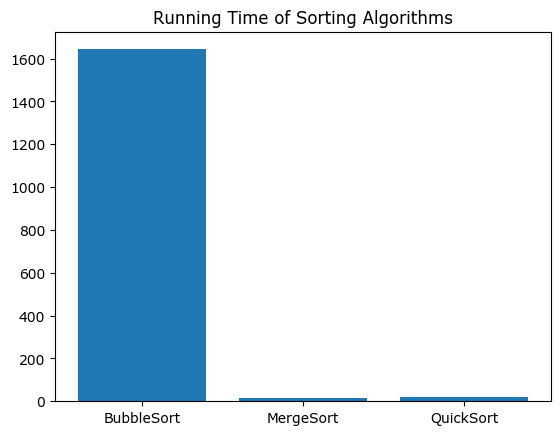

In [73]:
import matplotlib.pyplot as plt

names = ['BubbleSort', 'MergeSort', 'QuickSort']
values = [bubbleSortTime, mergeSortTime*10, quickSortTime*10] ##multiplied by 10 in order to show it in the plot
plt.bar(names, values)
plt.title('Running Time of Sorting Algorithms')
plt.show()

As you can see from the plot, the difference between an $O(N^2)$ algorithm and an $O(N log N)$ one is noticeable even though we are working on a relatively small instance.
Obviously, the worst algorithm is BubbleSort since has a bigger complexity.<br>
But which one is the best? As we saw from the running time analysis, MergeSort has the best running time, so I would personally choose Mergesort. But it's really important to note that, in the average case, Quicksort takes $O(N log N)$ and on our instance, it performed very well. <br> My choice of MergeSort is not only based on Time Complexity but also on Space Complexity since in the worst case QuickSort takes $O(N log N)$ space and MergeSort only $O(N)$. That may not seem important in our case, since we have a "small" instance, but if instead of 50.000 students, we had 50 million, we would have to think about Space Complexity for sure.

## MapReduce

In [76]:
import heapq
import collections

def mergesort (students, left, right):
  if left < right:
    center = (left+right)//2
    mergesort(students, left, center)
    mergesort(students, center+1, right)
    return merge(students, left, center, right)

def merge(s, left, center, right):
  i = left
  j = center +1 
  out = []
  while(i<center+1 and j<right+1):
    if(s[i]>s[j]):
      out.append(s[i])
      i+=1
    else:
      out.append(s[j])
      j+=1
  if(i<center+1):
    for k in range(i,center+1):
      out.append(s[k])
  elif (j<right+1):
    for k in range(j, right+1):
      out.append(s[k])
  for k in range(left, right+1):
    s[k] = out[k-left]
  return s

with open('ApplicantsInfo.txt') as f:
  content = f.read().splitlines()

##MAP
N, M = content[0].split()
studentDict = {}
studentList = []
for line in content[1:]:
  grades = []
  name, surname, *grades = line.split()
  fullName = name + ' ' + surname
  studentList.append(Student(fullName, grades))

##REDUCE
for singleStudent in studentList:
  try:
    heapq.heappush(studentDict[singleStudent.gradesAverage], singleStudent.name)
  except Exception as e:
    studentDict[singleStudent.gradesAverage] = [singleStudent.name]
    heapq.heapify(studentDict[singleStudent.gradesAverage])

#SHUFFLE
keyList = list(studentDict.keys()).copy()
keyList = mergesort(keyList, 0, len(studentDict.keys())-1)

with open("MapReduceRankingList.txt", "w") as file:
  for key in keyList:
    while(studentDict[key]):
      file.writelines('{} {}\n'.format(heapq.heappop(studentDict[key]), str(key)))
print('MapReduce end')

MapReduce end


The code above is, of course, just a fake MapReduce, but if we run it on a MapReduce framework like Hadoop, we would've seen something like this:

- the map function would've been computed by N clusters, and periodically, the input read and mapped, would've been passed to the reduce function.
- the reduce function, in the same way, would've been executed among M clusters and, similarly to the previous one, it would've passed its output to the shuffle function.<br>

In this way, the "big" amount of data that we are dealing with, would've been computed parallelly in a distributed architecture and the computational time would've been reduced: not because this algorithm is faster than the previous ones, but because it's running on multiple clusters.